# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete SSM.

In [3]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [52]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

# Generative Model

In [53]:
fg = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

@RV x_0 ~ Categorical(placeholder(:D_s, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

x_k_min = x_0
for k=1:2
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])
    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ DiscreteObservation{Generalized}(x[k], A, # Choose Generalized or Bethe constraint
                   placeholder(:C, dims=(16,), var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k] # For next slice
end
;

# Algorithm

In [54]:
q = PosteriorFactorization(y, [x_0; x], A, ids=[:Y, :X, :A])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
initX() = Array{Message}(undef, 9) # Predefine
eval(Meta.parse(code)) # Overwrites initX for Generalized constraint
;

In [55]:
# println(code)

## Action-Perception Loop

In [14]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 30 # Number of trials
R = 100 # Number of runs
seed = 1234 # Randomizer seed
;

In [56]:
include("helpers.jl")
include("environment.jl")
include("agent.jl")
include("visualizations.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

wins = [Vector{Float64}(undef, S) for ri=1:R]
params = Vector{Matrix}(undef, R)

@showprogress for r=1:R
    rs = generateGoalSequence(S) # Returns random goal sequence
    (reset, execute, observe) = initializeWorld(A, B, C, D, rs) # Let there be a world
    (infer, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

    # Step through the experimental protocol
    As = Vector{Matrix}(undef, S) # Posterior statistics for A
    Gs = [Vector{Matrix}(undef, 3) for s=1:S] # Free energy values per time
    as = [Vector{Int64}(undef, 2) for s=1:S] # Actions per time
    os = [Vector{Vector}(undef, 2) for s=1:S] # Observations (one-hot) per time
    for s = 1:S
        reset(s) # Reset world
        for t=1:2
            (Gs[s][t], _) = infer(t, as[s], os[s])
                 as[s][t] = act(t, Gs[s][t])
                            execute(as[s][t])
                 os[s][t] = observe()
        end
        (Gs[s][3], As[s]) = infer(3, as[s], os[s]) # Learn at t=3
    end
    wins[r] = extractWins(os)
    params[r] = deepcopy(As[end])
end
;

Progress: 100%|█████████████████████████████████████████| Time: 1:21:41


In [57]:
using FileIO, JLD2
FileIO.save("figures/wins.jld2","wins",wins,"params",params,"R",R,"S",S)

# Results

In [16]:
# Load data from file
using FileIO, JLD2, Plots, Statistics, Distributions
pairs = FileIO.load("figures/wins.jld2")
wins = pairs["wins"]
params = pairs["params"]
R = pairs["R"]
S = pairs["S"]
;

In [35]:
dist

Binomial{Float64}(n=30, p=0.811)

In [40]:
# Fit Binomial

win_counts = Int64.(sum.(wins))
dist = fit_mle(Binomial, S, win_counts)
p = Distributions.params(dist)[end]
f = pdf.(dist, 1:S).*R
f_ideal = pdf.(Binomial(S, α), 1:S).*R
;

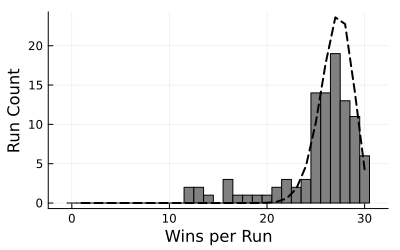

In [65]:
# Plot histogram for number of wins per run
histogram(win_counts, bins=-1:1:S, 
          dpi=300,
          size=(400,250),
          color=:gray, 
          label=false, 
          xlabel="Wins per Run", 
          ylabel="Run Count",
          legend=120,
          xticks=((0:10:30).-0.5, 0:10:30))

plot!((1:S).-0.5, f_ideal, linestyle=:dash, lw=2, color=:black, label=false)

# savefig("figures/GFE_hist.png")

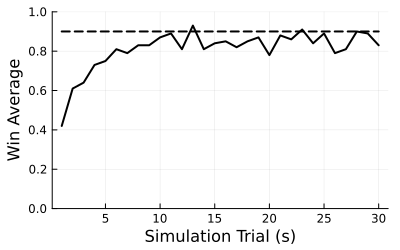

In [66]:
# Plot average wins per trial
m = mean(wins)

plot(1:S, m, ylim=(0,1),
     dpi=300,
     size=(400,250),
     color=:black, 
     lw=2, 
     label=false, 
     xlabel="Simulation Trial (s)", 
     ylabel="Win Average")
plot!(1:S, α.*ones(S), color=:black, linestyle=:dash, lw=2, label=false, legend=0)

# savefig("figures/GFE_wins.png")

In [85]:
# i_bot = findall(sum.(wins) .<= 20)

In [86]:
# r = 40
# plotObservationStatistics(params[r], A_0, title="Score: $(round(mean(wins[r]), digits=2))")

In [82]:
# include("visualizations.jl")
# for r=1:R
#     plotObservationStatistics(params[r], A_0, title="Score: $(mean(wins[r]))")
#     savefig("figures/params_$r.png")
# end
